# **1. DATA PREPARATION**

- Load Data
- Split To Train, Test, & Validation
- Membuat Folder Masing-Masing

## **A. LOAD DATA**

In [1]:
# Impor Module 

import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq

In [2]:
# Generate Data 

mypath= 'Data/'

file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name).replace('\\', '/')) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [3]:
# Create Data Frame

df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Laki-laki     969
Perempuan    1340
dtype: int64

In [4]:
# Cek Sampel Data (Random)

df.sample(5)

,path,file_name,tag
2243,Data/Perempuan/766_1.jpg,766_1.jpg,Perempuan
1856,Data/Perempuan/576_1.jpg,576_1.jpg,Perempuan
1349,Data/Perempuan/312_1.jpg,312_1.jpg,Perempuan
1499,Data/Perempuan/380_1.jpg,380_1.jpg,Perempuan
2224,Data/Perempuan/756_3.jpg,756_3.jpg,Perempuan


## **B. SPLIT TO TRAIN, VALIDATION, & TEST**

In [5]:
# Definisi Variable

X = df['path']
y = df['tag']

In [6]:
# Split To Train And Test

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify = y,
    test_size = 0.20, 
    random_state = 300)

In [7]:
# Create New Data Frame

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

In [8]:
# Cek Komposisi

print('train size', len(df_tr))
print('val size', len(df_te))

train size 1847
val size 462


In [9]:
# Cek Proporsi Masing-Masing

df_all = df_tr.append([df_te]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

# Cek Sample Datanya
df_all.sample(3)


set    tag      
test   Laki-laki     194
       Perempuan     268
train  Laki-laki     775
       Perempuan    1072
dtype: int64 




,path,tag,set
456,Data/Perempuan/297_1.jpg,Perempuan,train
1026,Data/Perempuan/701_1.jpg,Perempuan,train
1512,Data/Perempuan/15_1.jpg,Perempuan,train


## **C. MEMBUAT FOLDER MASING-MASING**

In [10]:
# Define Path 

datasource_path = "Data/"
dataset_path = "Dataset F1 Score Adamax/"

In [11]:
# Membuat Folder Destinasi

for index, row in tq(df_all.iterrows()):
    
    # Detect Filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    # Make Folder Festination Dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    # Define File Dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    # Copy File From Source To Dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **2. MODEL TRAIN & EVALUATION**

- Prepare Model
- Membuat Struktur CNN & Prebuilt Model
- Train Model
- Evaluate Model

## **A. PREPARE MODEL**

In [12]:
# Module

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB1
from matplotlib import pyplot as plt

In [13]:
# Define F1-Score Metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# Define Input Parameters

dim = (150, 150)
channel = (3, )
input_shape = dim + channel
batch_size = 16
epoch = 10

In [15]:
# Define Data Generator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [16]:
# Define Initial Path

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 1847 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [17]:
# Create Tensorflow Data

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [18]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)

## **B. MEMBUAT STRUKTUR CNN & PRE BUILT MODEL**

In [19]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile The Model
print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=[f1_m])

# Model Summary
model.summary()

Compiling Model.......
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      36896     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (Non

In [20]:
# Pre Built Model

base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

In [21]:
#Adding custom layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [22]:
# Compile the model

print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=[f1_m])

Compiling Model.......


In [23]:
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

In [24]:
# Adding custom layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [25]:
# Compile the model

print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=[f1_m])

Compiling Model.......


## **C. TRAIN MODEL**

In [42]:
# Model Train

EPOCH = 50

history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=test_data,
        validation_steps=len(test_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/50
116/116 [==============================] - 241s 2s/step - loss: 0.0185 - f1_m: 0.9935 - val_loss: 0.3435 - val_f1_m: 0.9405
Epoch 2/50
116/116 [==============================] - 243s 2s/step - loss: 0.0072 - f1_m: 0.9978 - val_loss: 0.2886 - val_f1_m: 0.9500
Epoch 3/50
116/116 [==============================] - 237s 2s/step - loss: 0.0192 - f1_m: 0.9925 - val_loss: 0.3049 - val_f1_m: 0.9458
Epoch 4/50
116/116 [==============================] - 239s 2s/step - loss: 0.0272 - f1_m: 0.9941 - val_loss: 0.3206 - val_f1_m: 0.9375
Epoch 5/50
116/116 [==============================] - 216s 2s/step - loss: 0.0170 - f1_m: 0.9930 - val_loss: 0.3885 - val_f1_m: 0.9292
Epoch 6/50
116/116 [==============================] - 210s 2s/step - loss: 0.0155 - f1_m: 0.9935 - val_loss: 0.3039 - val_f1_m: 0.9363
Epoch 7/50
116/116 [==============================] - 214s 2s/step - loss: 0.0156 - f1_m: 0.9941 - val_loss: 0.2212 - val_f1_m: 0.9542
Epoch 8/50
116/116 [==============================] - 2

In [43]:
# Accuracy Check
history.history['f1_m']

[0.993534505367279,
 0.9978448152542114,
 0.9924569129943848,
 0.9940732717514038,
 0.9929956793785095,
 0.993534505367279,
 0.9940732717514038,
 0.990840494632721,
 0.990840494632721,
 0.9924569129943848,
 0.9973060488700867,
 0.9967672228813171,
 0.9973060488700867,
 0.9994612336158752,
 0.9933804869651794,
 0.9951508641242981,
 0.993534505367279,
 0.9951508641242981,
 0.9949969053268433,
 0.9946120977401733,
 0.9951508641242981,
 0.9989224076271057,
 0.9966132640838623,
 0.9962284564971924,
 0.9951508641242981,
 0.9964593648910522,
 0.998383641242981,
 0.9973060488700867,
 0.9948430061340332,
 0.9989224076271057,
 0.9967672228813171,
 0.998383641242981,
 0.998383641242981,
 0.9967672228813171,
 0.9994612336158752,
 0.9994612336158752,
 0.9962284564971924,
 0.9978448152542114,
 0.9962284564971924,
 0.9962284564971924,
 0.998383641242981,
 0.9967672228813171,
 0.9978448152542114,
 0.9967672228813171,
 0.995535671710968,
 0.9978448152542114,
 0.9994612336158752,
 0.9973060488700867,
 0

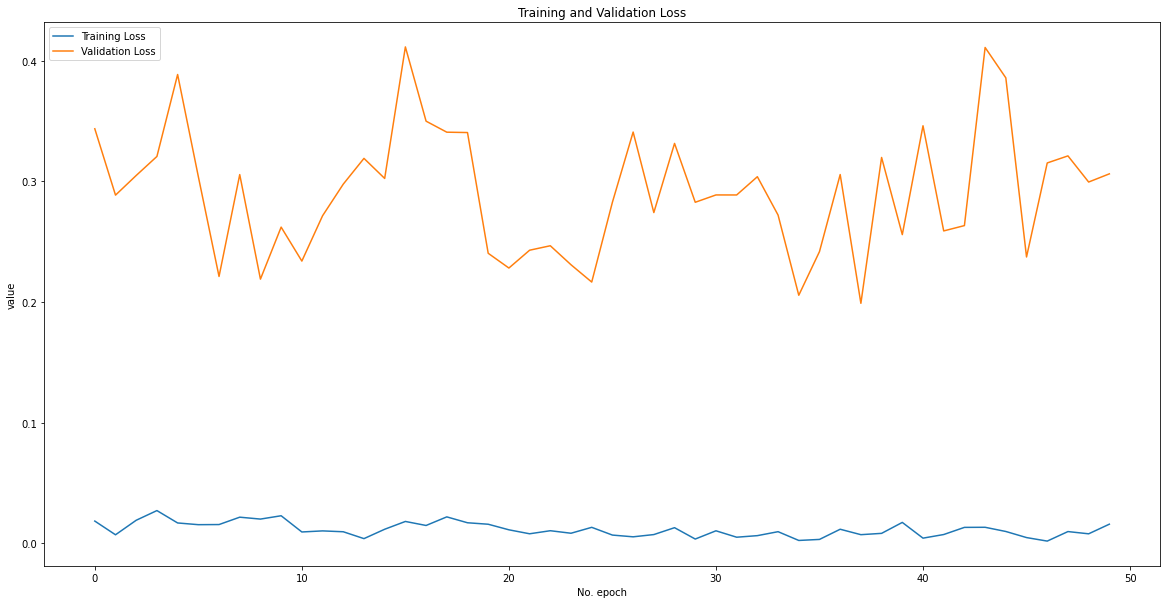

In [44]:
# Ploting Loss
plt.figure(figsize = (20,10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

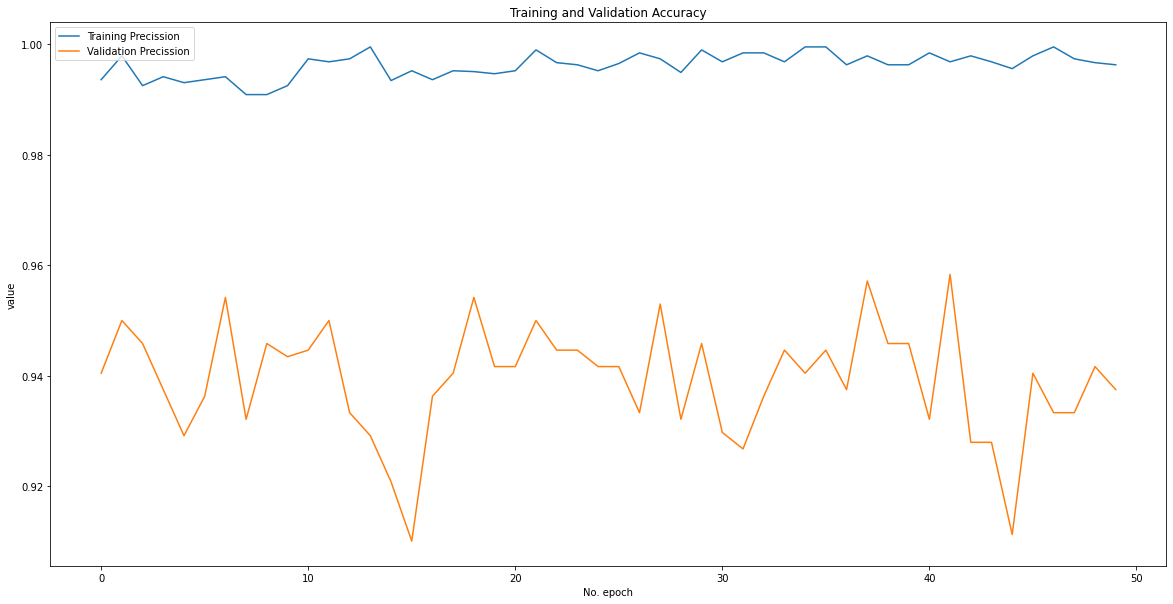

In [45]:
# Ploting Accuarcy 
plt.figure(figsize = (20,10))
plt.plot(history.history['f1_m'], label='Training Precission')
plt.plot(history.history['val_f1_m'], label='Validation Precission')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **C. MODEL EVALUATION**

In [46]:
loss, acc = model.evaluate(train_data,steps=len(train_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 1.0000 
Loss on training data: 0.0001 

Accuracy on test data: 0.9500 
Loss on test data: 0.2453 



# **3. PREDICTION**

In [47]:
from PIL import Image
import numpy as np

In [48]:
# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['Laki-Laki', 'Perempuan']

In [49]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [60]:
# read image
im = Image.open('Data/Perempuan/466_3.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

Perempuan 1.0
